In [8]:
import requests

In [21]:
res = requests.post(
    # "https://api.dev.mediaimpactmonitor.app/events",
    "http://localhost:8000/events",
    json={
        "event_type": "protest",
        "source": "acled",
        "topic": "climate_change",
        "start_date": "2023-07-01",
        "end_date": "2023-12-31",
        "organizers": ["Last Generation (Germany)"],
        "estimate_impact": "true",
    },
)
res.json()
events = res.json()["data"]
event_ids = [event["event_id"] for event in events]
events[0]

{'event_id': '9064cc0660a50363ec2d44a8fe51b376',
 'event_type': 'protest',
 'source': 'acled',
 'date': '2023-12-15',
 'organizers': ['Last Generation (Germany)'],
 'description': 'On 15 December 2023, about 15 Last Generation activists blocked streets at various places across Koln (Nordrhein-Westfalen), demanding immediate climate change. Law enforcers quickly removed them and resumed traffic.',
 'impact': -258.2699966430664}

count     151.000000
mean       60.567447
std       534.719841
min     -2355.171185
25%      -305.347025
50%        11.885155
75%       474.545919
max      1086.381624
dtype: float64


<Axes: >

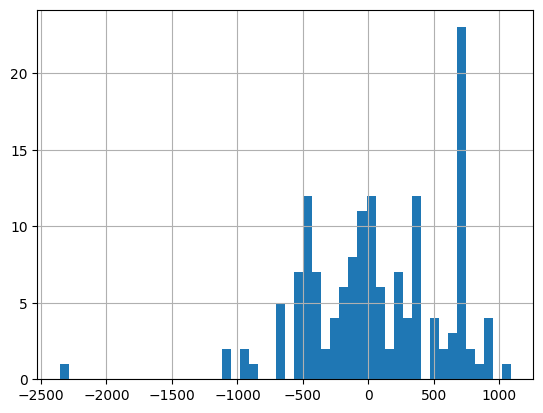

In [26]:
import pandas as pd

impacts_ = pd.Series([event["impact"] for event in events])
print(impacts_.describe())
impacts_.hist(bins=50)

In [27]:
res = requests.post(
    # "https://api.dev.mediaimpactmonitor.app/impact",
    "http://localhost:8000/impact",
    json={
        "cause": event_ids,
        "effect": {
            "trend_type": "keywords",
            "media_source": "news_online",
            "topic": "climate_change",
            "query": '"Letzte Generation"',
        },
        "method": "interrupted_time_series",
    },
)
data = res.json()["data"]

<Axes: >

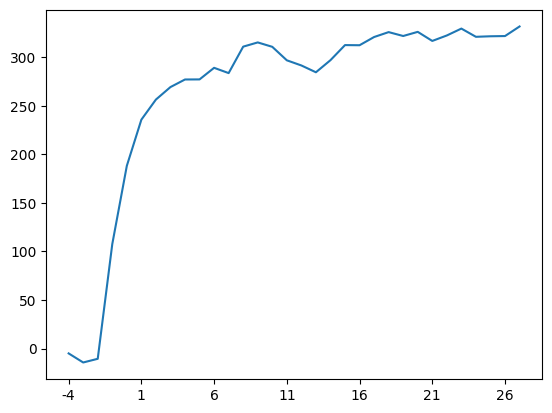

In [28]:
import pandas as pd

pd.Series(data["impact_average"]).plot()

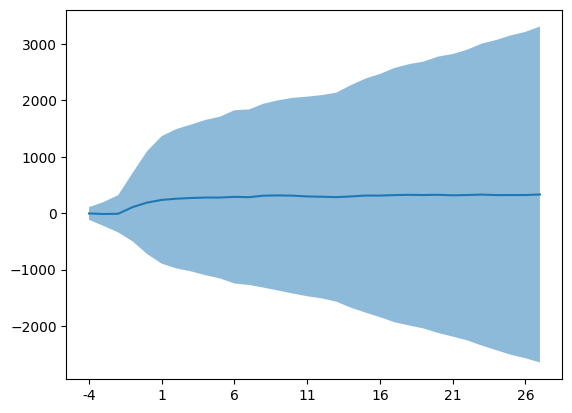

In [29]:
import matplotlib.pyplot as plt

pd.Series(data["impact_average"]).plot()
plt.fill_between(
    pd.Series(data["impact_average"]).index,
    pd.Series(data["impact_average_lower"]).values,
    pd.Series(data["impact_average_upper"]).values,
    alpha=0.5,
)